In [577]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from os import listdir
import unicodedata


from paths import *
# from scripts.vis_graphs import remove_acentos
# from scripts.vis_graphs import normalize_cols
from scripts.io import read_sheets
from scripts import vis_maps

from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


import yaml

In [482]:
## load cases table
df = read_sheets('covid19_taubate')
bairos = list(np.sort(df['bairro'].unique()))

#load neighborhood lat lon
df_bairos = read_sheets('covid19_taubate', 'bairros')
bairos_latlon = df_bairos.bairro.tolist()

#chek if all neighborhood had a lat lon
compare_bairos = [bairo for bairo in bairos if bairo not in bairos_latlon]
compare_bairos

[]

In [483]:
## prepare data
df = df.merge(df_bairos, on='bairro', how='left')

mask = ((df['status']!='xxx') & (df['lat_lon']!='xxx'))
df = df[mask]

df['lat'] = df['lat_lon'].apply(lambda x: x.split(',')[0]).astype(float)
df['lon'] = df['lat_lon'].apply(lambda x: x.split(',')[1]).astype(float)

df['data'] = pd.to_datetime(df['data'], format = "%d/%m/%Y")

In [522]:
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

status_adjusts = {
    'analise':{
        'color':'#EF9B0F',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos em Análise:</b> {}" ### nome do bairro e quantidade da metrica
    },
    'confirmado':{
        'color':'blue',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos Confirmados:</b> {}"
    },
    'obito':{
        'color':'red',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Óbitos:</b> {}"
    },
    
    'descartado':{
        'color':'green',             
        'text':"<b>Bairro:</b> {} <br> <br> <b>Casos Descartados:</b> {}"
    },
}

config['taubate_map']
m = vis_taubate.get_map_taubate(df, status_adjusts, config['taubate_map'], save=False)



In [544]:
dd = df.drop(['lat_lon','lat','lon'],1)

for status in dd['status'].unique():
    mask = dd['status']==status
    dd[status] = np.where(mask, 1, 0)
    
    
dd = dd.drop(['status'],1)


casos_taubate = dd.groupby('data',as_index=False).sum()
casos_taubate['analise_sum'] = casos_taubate['analise'].cumsum()
casos_taubate['descartado_sum'] = casos_taubate['descartado'].cumsum()
casos_taubate['confirmado_sum'] = casos_taubate['confirmado'].cumsum()
casos_taubate['obito_sum'] = casos_taubate['obito'].cumsum()

In [538]:
from scripts import vis_taubate
themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

adjusts = {
    'analise'   : {'nome':'Em Análise' ,'cor':'#EF9B0F'},
    'confirmado': {'nome':'Confirmados','cor':'blue'    },
    'obito': {'nome':'Óbitos','cor':'red'    },
    'descartado': {'nome':'Descartados','cor':'green'  },

}

fig = vis_taubate.taubate_daily(casos_taubate,themes['taubate'], adjusts, config['taubate_daily'],save=False)

Done!


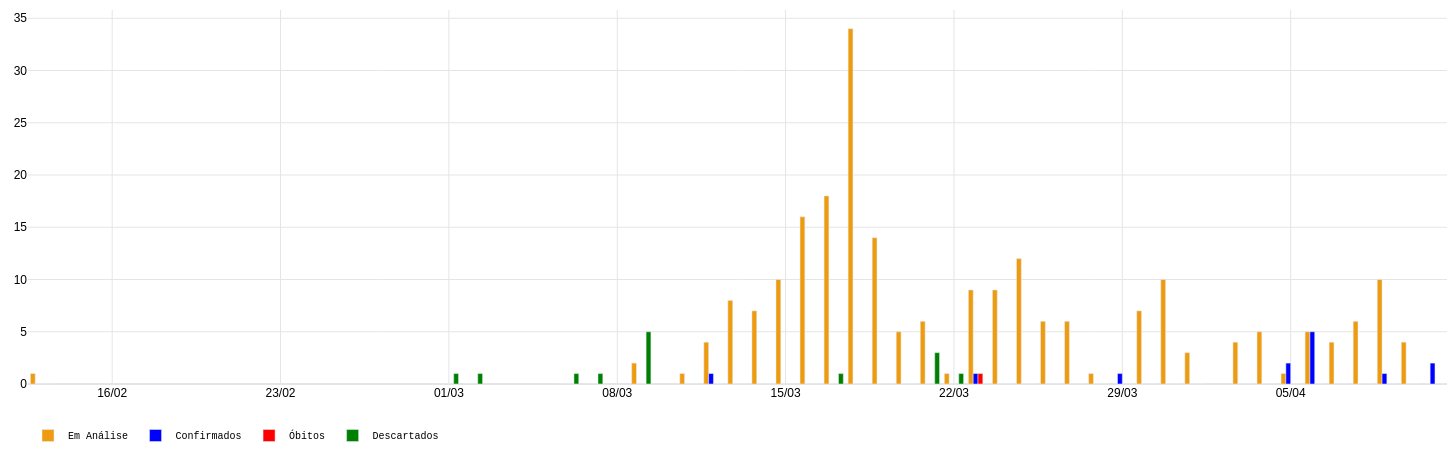

In [537]:
fig

In [559]:
from scripts import vis_layout
from scripts import vis_taubate

themes = yaml.load(open('../themes/themes_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)

adjusts = {
    'analise_sum'   : {'nome':'Em Análise' ,'cor':'#EF9B0F'},
    'confirmado_sum': {'nome':'Confirmados','cor':'blue'    },
    'obito_sum': {'nome':'Óbitos','cor':'red'    },
    'descartado_sum': {'nome':'Descartados','cor':'green'  },
}

fig = vis_taubate.taubate_cum(casos_taubate, themes['taubate'], adjusts, config['taubate_cumulative'],save=False)

In [ ]:
fig

In [532]:
from scripts import vis_taubate

In [552]:
config = yaml.load(open('../configs/config_taubate.yaml', 'r') ,Loader = yaml.FullLoader)
vis_taubate.taubate_update_html(casos_taubate, config['embed_html'], save=False)

Done!
Embed html uploaded!


In [587]:
today

'2020-04-14'